In [1]:
# Imports and defaults
import itertools
import joblib
from joblib import Parallel, delayed
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from oohf import *
import pandas as pd
import time
from tqdm.auto import tqdm

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [6, 4]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["errorbar.capsize"] = 3
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)
print("%d joblib CPUs" % joblib.cpu_count())

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.10.14
matplotlib 3.9.2
64 joblib CPUs


/home/kkt/miniforge3/envs/dope2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def d_grad(V, p, gamma=1e-6, return_grad=True, subset=None):
  """Value of D-optimal objective and its gradient.

  V: n x d x d matrix of feature-vector outer products
  p: distribution over feature vectors (design)
  """
  n, d, _ = V.shape

  # inverse of the sample covariance matrix
  G = np.einsum("ijk,i->jk", V, p) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value (log det)
  sign, obj = np.linalg.slogdet(G)
  obj *= - sign
  if return_grad:
    # gradient of the objective
    if subset is None:
      M = np.einsum("kl,ilj->ikj", invG, V)
      dp = - np.trace(M, axis1=-2, axis2=-1)
    else:
      M = np.einsum("kl,ilj->ikj", invG, V[subset, :, :])
      dp = np.zeros(n)
      dp[subset] = - np.trace(M, axis1=-2, axis2=-1)
  else:
    dp = 0

  return obj, dp


def fw_design(V, pi_0=None, R=None, num_iters=100, tol=1e-6, printout=True):
  """Frank-Wolfe algorithm for design optimization.

  V: n x d x d matrix of feature-vector outer products
  pi_0: initial distribution over feature vectors (design)
  R: number of subsampled feature vectors in each iteration
  num_iters: maximum number of Frank-Wolfe iterations
  tol: stop when two consecutive objective values differ by less than tol
  """
  n, d, _ = V.shape
  if pi_0 is None:
    # initial allocation weights are 1 / n and they add up to 1
    pi = np.ones(n) / n
  else:
    pi = np.copy(pi_0)
  if R is None:
    R = n

  # Frank-Wolfe iterations
  for iter in range(num_iters):
    # compute gradient at the last solution
    pi_last = np.copy(pi)
    if R == n:
      # Dope
      last_obj, grad = d_grad(V, pi_last)
    else:
      # DopeWolfe
      last_obj, grad = d_grad(V, pi_last, subset=np.random.permutation(n)[: R])

    if iter == 0:
      obj_s = [last_obj]

    if printout:
      print("%.4f" % last_obj, end=" ")

    # find a feasible LP solution in the direction of the gradient
    pi_lp = np.zeros(n)
    pi_lp[np.argmin(grad)] = 1.0

    # golden-section search in the direction of the gradient
    num_ls_iters = 20
    left_step = 0
    left_obj, _ = d_grad(V, pi_last, return_grad=False)
    right_step = 1.0
    right_obj, _ = d_grad(V, pi_lp, return_grad=False)

    for ls_iter in range(num_ls_iters):
      mid1 = left_step + 0.618 * (right_step - left_step)
      obj1, _ = d_grad(V, mid1 * pi_lp + (1 - mid1) * pi_last, return_grad=False)
      mid2 = right_step - 0.618 * (right_step - left_step)
      obj2, _ = d_grad(V, mid2 * pi_lp + (1 - mid2) * pi_last, return_grad=False)

      if obj1 < obj2:
        left_step = mid2
        left_obj = obj2
      else:
        right_step = mid1
        right_obj = obj1
    best_step = (left_step + right_step) / 2

    # update solution
    pi = best_step * pi_lp + (1 - best_step) * pi_last
    best_obj, _ = d_grad(V, pi, return_grad=False)
    obj_s.append(best_obj)

    # if last_obj - best_obj < tol:
    #   break;
    if R==n and last_obj - best_obj < tol:
      break;
    elif R!=n and len(obj_s) > 2*(n//R) and obj_s[-(n//R)-1] - best_obj < tol: 
      break;
    iter += 1

  if printout:
    print()

  pi = np.maximum(pi, 0)
  pi /= pi.sum()
  return pi

..................................................


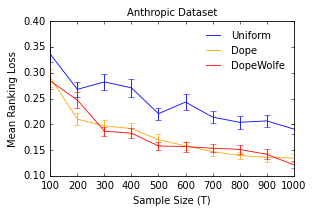

Computation time:
   Uniform: 0.000 +/- 0.000
      Dope: 20.147 +/- 0.008
 DopeWolfe: 6.184 +/- 0.006
..................................................


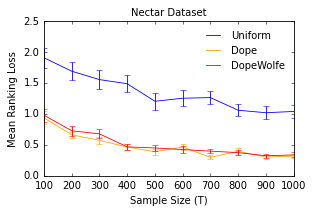

Computation time:
   Uniform: 0.000 +/- 0.000
      Dope: 0.960 +/- 0.000
 DopeWolfe: 0.411 +/- 0.022


In [4]:
num_logged = np.arange(100, 1100, 100)  # number of logged data points
# num_logged = np.arange(1000, 1100, 100)  # number of logged data points
n_max = num_logged.max()
num_runs = 50

for dataset in ["Anthropic", "Nectar"]:
  Phi = np.load("%s_features.npy" % dataset.lower())  # features
  N = Phi.shape[0]  # number of data points
  K = Phi.shape[1]  # number of answers
  d = Phi.shape[2]  # number of features

  algs = [
    (0, "Uniform", "blue", "-", "Uniform"),
    (1, "Dope", "orange", "-", "Dope"),
    (2, "DopeWolfe", "red", "-", "DopeWolfe")]
  num_algs = len(algs)

  errors = np.zeros((num_algs, num_runs, n_max + 1))
  times = np.zeros((num_algs, num_runs))
  for run in range(num_runs):
    print(".", end="")

    theta_star = np.random.randn(d)  # model parameter
    V = np.zeros((N, d, d))  # feature outer products
    for i in range(K):
      for j in range(i + 1, K):
        dX = Phi[:, i, :] - Phi[:, j, :]
        V += np.einsum("ti,tj->tij", dX, dX)

    for alg in algs:
      start = time.time()
      if alg[1] == "Uniform":
        pi = np.ones(N) / N
      elif alg[1] == "Dope":
        pi = fw_design(V, printout=False)
      elif alg[1] == "DopeWolfe":
        pi = fw_design(V, R=N // 10, printout=False)
      times[alg[0], run] = time.time() - start

      # log data
      Phi_log = np.zeros((n_max, K, d))
      for t in range(n_max):
        i = np.random.choice(N, p=pi)
        Phi_log[t, :, :] = Phi[i, :, :]

      # estimate model and evaluate it
      for t in num_logged:
        model = PlackettLuce(Phi_log[: t, :, :])  # initialize PL class for the logged data
        A = model.sample(K, theta_star)  # collect feedback
        theta_hat = model.mle(A)  # estimate model parameter

        # ranking loss
        loss = 0
        for i in range(K):
          for j in range(i + 1, K):
            dX = Phi[:, i, :] - Phi[:, j, :]
            loss += (np.sign(dX.dot(theta_star)) != np.sign(dX.dot(theta_hat))).sum()
        errors[alg[0], run, t] = loss / N
  print()

  # plots
  plt.figure(figsize=(4, 2.75))
  for alg in algs:
    y = errors[alg[0], :, :][:, num_logged]
    plt.plot(num_logged, y.mean(axis=0),
      alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
    plt.errorbar(num_logged, y.mean(axis=0),
      y.std(axis=0) / np.sqrt(num_runs),
      fmt="none", ecolor=alg[2])

    plt.title("%s Dataset" % dataset)
    plt.xlabel("Sample Size (T)")
    plt.xlim(num_logged[0], num_logged[-1])
    plt.ylabel("Mean Ranking Loss")
    plt.legend(loc="best", frameon=False)

  plt.tight_layout()
  plt.savefig("Results/%s.pdf" % dataset.lower(), format="pdf", dpi=1200, bbox_inches=0)
  plt.show()

  print("Computation time:")
  for alg in algs:
    print("%10s: %.3f +/- %.3f" %
      (alg[4], times[alg[0], :].mean(axis=-1), times[alg[0], :].std(axis=-1) / np.sqrt(num_runs)))